In [1]:
from IPython.display import HTML
HTML('''<script>

code_show=true;

function code_toggle() {

if (code_show){

$('div.input').hide();

} else {

$('div.input').show();

}

code_show = !code_show

}

$( document ).ready(code_toggle);

</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve 
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
import metrics
import pickle
%pylab inline
pd.set_option('display.max_column',None)

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


## 2. Generate dataset
I will use the script [dataset_for_modeling.py](./dataset_for_modeling.py) that prepares the data as explained in the Exploratory Data Analysis ([Data_modeling_notebook chapter 2](./TBV1_classification_model.ipynb))

In [3]:
import dataset_for_modeling

Total sample reserved: 445
Total population before train and test split: 8448
X_train, y_train, X_test, y_test and data_reserved returned


In [4]:
X_train = dataset_for_modeling.X_train
y_train = dataset_for_modeling.y_train
X_test = dataset_for_modeling.X_test
y_test = dataset_for_modeling.y_test

## 3.  Random Forest tuning
**This part is composed of following chapters:**  
1) Random Forest with Randomized Search     
2) Random Forest with Gridsearch, score = recall  
3) Random Forest with Gridsearch, score = AUC     
 

Next, there are general assumptions for all the models:   

**Managing imabalanced data**:  with class_weight 
  

**Metrics**: AUC, Recall, Precision & Recal curve, f1_score, Cummulative Gain and Lift (only with best estimator)


**Modeling Steps**:   
1) Generate Classifier (Gridsearch for Random Forest and XGboost)   
2) Fit   
3) Metrics  
4) Compare results   

### 1) Random Forest with Randomized search (clf_rft_rs)

#### 1) Classifier

In [5]:
# Pipeline: scaler and classifier
pipe_rft = Pipeline([('scaler',StandardScaler()),
                    ('classifier', RandomForestClassifier(class_weight='balanced'))])

# params to be tuned
param_grid={'classifier__n_estimators':np.arange(20,50,10),
            'classifier__max_features':['log2','auto',3,5,10,20],
            'classifier__max_depth':np.arange(3,10),          
            'classifier__min_samples_leaf': np.arange(10,30),
            'classifier__bootstrap': [True,False],
            'classifier__criterion': ['gini','entropy']
                         }
#classifier
clf_rft_rs = RandomizedSearchCV(pipe_rft,param_grid,n_iter=20,cv = 5,
                            iid=True,verbose=2,random_state=42,
                            n_jobs = -1, scoring = 'recall')

#### **2) Fit the model**

In [6]:
clf_rft_rs.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight='balanced',
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                 

**Best_parameters and score ('recall')**

In [7]:
# hiperparámetros
clf_rft_rs.best_params_, clf_rft_rs.best_score_

({'classifier__n_estimators': 30,
  'classifier__min_samples_leaf': 20,
  'classifier__max_features': 10,
  'classifier__max_depth': 3,
  'classifier__criterion': 'gini',
  'classifier__bootstrap': False},
 0.7000035873704062)

**3) Metrics**  
**Confussion matrix and classification report**  
I this case the 'closed' recall is **0.67** (higher than random forest basic that was 0.60).  
Although precision is lower than random forest basic: **0.11** vs 0.12   
Anyhow, this outperforms baseline in all metrics

In [8]:
#predict class values
pred_rft_rs = clf_rft_rs.best_estimator_.predict(X_test)

#confussion matrix
metrics.plot_cm(y_test,pred_rft_rs)

Confusion matrix:
[[1472  914]
 [  48  101]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75      2386
           1       0.10      0.68      0.17       149

    accuracy                           0.62      2535
   macro avg       0.53      0.65      0.46      2535
weighted avg       0.92      0.62      0.72      2535



**Roc - Auc**   

No Skill: ROC AUC=0.500
Random Forest RS: ROC AUC=0.702


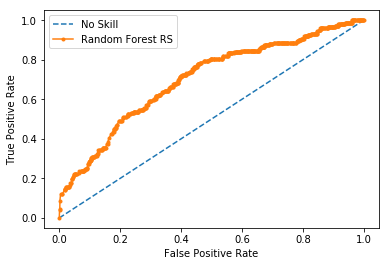

In [9]:
# predict probabilities
rft_rs_prob = clf_rft_rs.best_estimator_.predict_proba(X_test)

# keep probabilities for the positive outcome only
rft_rs_prob = rft_rs_prob[:,1]

# calculate AUC and ROC curve
rft_rs_auc_roc, rft_rs_fpr, rft_rs_tpr, _rft_rs_th = metrics.plot_roc_curve(y_test,rft_rs_prob
                                                                            ,'Random Forest RS')

**Precision-recall curve**  

Random Forest RS: f1=0.174 auc=0.202


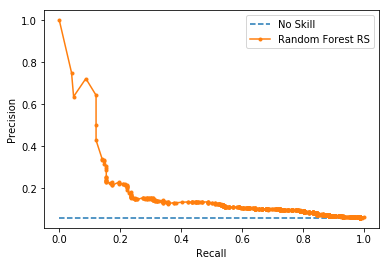

In [10]:
# precision, recall and f1
rft_rs_f1, rft_rs_precision, rft_rs_recall = metrics.plot_prec_rec(y_test,pred_rft_rs,rft_rs_prob,
                                                                   'Random Forest RS')

**4) Results**  
I load the results in the results DataFrame to compare the outputs of different models.
Here I don't need to perform crossvalidation since the best estimator has been selected with Gridsearch

In [11]:
result = pd.DataFrame(index=['recall', 'auc_roc','f1'])
result['clf_rf_tuned_rs'] = [recall_score(y_test,pred_rft_rs),
                             rft_rs_auc_roc,
                             rft_rs_f1]

In [12]:
result

,clf_rf_tuned_rs
recall,0.677852
auc_roc,0.701643
f1,0.173540


### 2) Gridsearch - optimize recall (clf_rft_gsr)

#### 1) Classifier

In [13]:
# Pipeline: scaler and classifier
pipe_rft = Pipeline([('scaler',StandardScaler()),
                    ('classifier', RandomForestClassifier(class_weight='balanced'))])

# params to be tuned
param_grid={'classifier__n_estimators':np.arange(20,50,10),
            'classifier__max_features':['auto','log2'],
            'classifier__max_depth':np.arange(3,10),          
            'classifier__min_samples_leaf': np.arange(10,30),
            'classifier__bootstrap': [True,False],
            'classifier__criterion': ['gini','entropy']
                         }
#classifier
clf_rft_gsr = GridSearchCV(pipe_rft,param_grid,cv = 5,
                            iid=True,verbose=2,
                            n_jobs = -1, scoring = 'recall')

#### **2) Fit the model**

In [14]:
clf_rft_gsr.fit(X_train,y_train)

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3958 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 5172 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 6550 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 9790 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 11652 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 13678 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 15864 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 16800 out of 1

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
     

**Best_parameters and score ('recall')**

In [15]:
# hiperparámetros
clf_rft_gsr.best_params_, clf_rft_gsr.best_score_

({'classifier__bootstrap': False,
  'classifier__criterion': 'entropy',
  'classifier__max_depth': 4,
  'classifier__max_features': 'auto',
  'classifier__min_samples_leaf': 13,
  'classifier__n_estimators': 30},
 0.696974821784563)

**3) Metrics**  
**Confussion matrix and classification report**  

In [16]:
#predict class values
pred_rft_gsr = clf_rft_gsr.best_estimator_.predict(X_test)

#confussion matrix
metrics.plot_cm(y_test,pred_rft_gsr)

Confusion matrix:
[[1528  858]
 [  47  102]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      2386
           1       0.11      0.68      0.18       149

    accuracy                           0.64      2535
   macro avg       0.54      0.66      0.48      2535
weighted avg       0.92      0.64      0.74      2535



**Roc - Auc**   

No Skill: ROC AUC=0.500
Random Forest GS_recall: ROC AUC=0.718


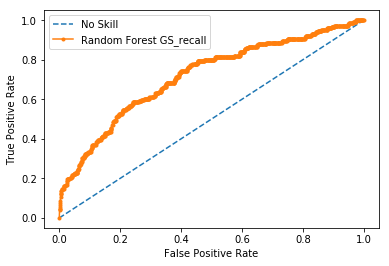

In [17]:
# predict probabilities
rft_gsr_prob = clf_rft_gsr.best_estimator_.predict_proba(X_test)

# keep probabilities for the positive outcome only
rft_gsr_prob = rft_gsr_prob[:,1]

# calculate AUC and ROC curve
rft_gsr_auc_roc, rft_gsr_fpr, rft_gsr_tpr, _rft_gsr_th = metrics.plot_roc_curve(y_test,rft_gsr_prob
                                                                                ,'Random Forest GS_recall')

**Precision-recall curve**  

Random Forest GS_recall: f1=0.184 auc=0.220


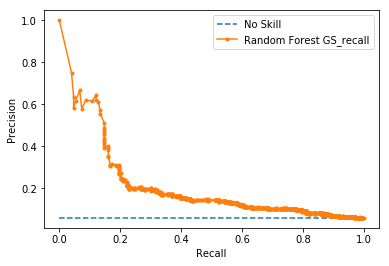

In [18]:
# precision, recall and f1
rft_gsr_f1, rft_gsr_precision, rft_gsr_recall = metrics.plot_prec_rec(y_test,pred_rft_gsr,rft_gsr_prob,
                                                                      'Random Forest GS_recall')

**Roc and precision and recall curves** to check possible overfitting   
The AUC is lower in training than in test!! The same that with Xgboost. In this case I have used Gridsearch with cv. I have been reading that the hyperparameters could be overfitted also. I need to analyse this effect a bit more.

No Skill: ROC AUC=0.500
Random Forest train: ROC AUC=0.702


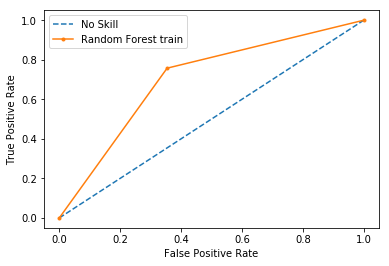

In [19]:
# AUC and Roc curve for training set
pred_train_rf = clf_rft_gsr.best_estimator_.predict(X_train)
predic_prob_train_rf =  clf_rft_gsr.best_estimator_.predict_proba(X_train)[:,1]
a,b,c,d = metrics.plot_roc_curve(y_train,pred_train_rf, 'Random Forest train')

Random Forest train: f1=0.195 auc=0.227


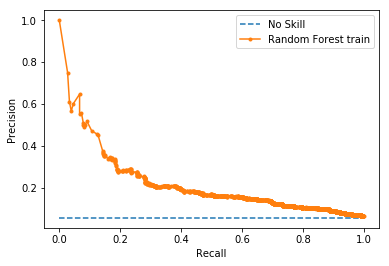

In [20]:
# Precision and recall curve for training set
x, y, z = metrics.plot_prec_rec(y_train,pred_train_rf,predic_prob_train_rf, 
                              'Random Forest train')

**4) Results on test set**  
I load the results in the results DataFrame to compare the outputs of different models.
Here, I don't need to perform crossvalidation since the best estimator has been selected with Gridsearch and cv

In [21]:
result['clf_rf_tuned_gsr'] = [recall_score(y_test,pred_rft_gsr),
                             rft_gsr_auc_roc,
                             rft_gsr_f1]

In [22]:
result

,clf_rf_tuned_rs,clf_rf_tuned_gsr
recall,0.677852,0.684564
auc_roc,0.701643,0.718005
f1,0.173540,0.183950


### 3) Gridsearch - optimize AUC (clf_rft_gsa)

In [23]:
# Pipeline: scaler and classifier
pipe_rft = Pipeline([('scaler',StandardScaler()),
                    ('classifier', RandomForestClassifier(class_weight='balanced'))])

# params to be tuned
param_grid={'classifier__n_estimators':np.arange(10,40,10),
            'classifier__max_features':['auto','log2'],
            'classifier__max_depth':np.arange(3,10),          
            'classifier__min_samples_leaf': np.arange(10,30),
            'classifier__bootstrap': [True,False],
            'classifier__criterion': ['gini','entropy']
                         }
# With Gridsearch
clf_rft_gsa = GridSearchCV(pipe_rft,param_grid,cv = 5,
                            iid=True,verbose=2,
                            n_jobs = -1, scoring = 'roc_auc')

#### **2) Fit the model**

In [24]:
clf_rft_gsa.fit(X_train,y_train)

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 5804 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 7912 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 10340 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 13096 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 16172 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 16800 out of 16800 | elapsed: 18.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
     

**Best_parameters and score ('auc')**

In [25]:
# hiperparámetros
clf_rft_gsa.best_params_, clf_rft_gsa.best_score_

({'classifier__bootstrap': False,
  'classifier__criterion': 'gini',
  'classifier__max_depth': 9,
  'classifier__max_features': 'auto',
  'classifier__min_samples_leaf': 16,
  'classifier__n_estimators': 30},
 0.7663550152704794)

**3) Metrics**  
**Confussion matrix and classification report**  

In [26]:
#predict class values
pred_rft_gsa = clf_rft_gsa.best_estimator_.predict(X_test)

#confussion matrix
metrics.plot_cm(y_test,pred_rft_gsa)

Confusion matrix:
[[1839  547]
 [  58   91]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      2386
           1       0.14      0.61      0.23       149

    accuracy                           0.76      2535
   macro avg       0.56      0.69      0.55      2535
weighted avg       0.92      0.76      0.82      2535



**Roc - Auc**   

No Skill: ROC AUC=0.500
Random Forest GS_auc: ROC AUC=0.758


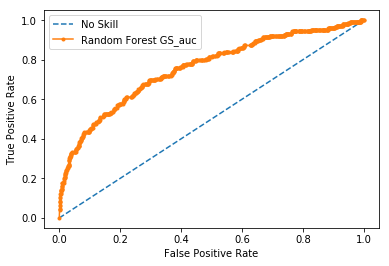

In [27]:
# predict probabilities
rft_gsa_prob = clf_rft_gsa.best_estimator_.predict_proba(X_test)

# keep probabilities for the positive outcome only
rft_gsa_prob = rft_gsa_prob[:,1]

# calculate AUC and ROC curve
rft_gsa_auc_roc, rft_gsa_fpr, rft_gsa_tpr, _rft_gsa_th = metrics.plot_roc_curve(y_test,rft_gsa_prob
                                                                                ,'Random Forest GS_auc')

**Precision-recall curve**  

Random Forest GS_auc: f1=0.231 auc=0.274


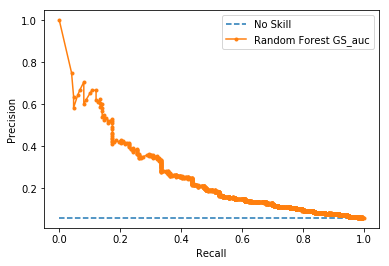

In [28]:
# precision, recall and f1
rft_gsa_f1, rft_gsa_precision, rft_gsa_recall = metrics.plot_prec_rec(y_test,pred_rft_gsa,rft_gsa_prob,
                                                                      'Random Forest GS_auc')

**4) Results**  
I load the results in the results DataFrame to compare the outputs of different models.
Here I don't need to perform crossvalidation since the best estimator has been selected with Gridsearch

In [29]:
result['clf_rf_tuned_gsa'] = [recall_score(y_test,pred_rft_gsa),
                             rft_gsa_auc_roc,
                             rft_gsa_f1]

In [30]:
result

,clf_rf_tuned_rs,clf_rf_tuned_gsr,clf_rf_tuned_gsa
recall,0.677852,0.684564,0.610738
auc_roc,0.701643,0.718005,0.758004
f1,0.173540,0.183950,0.231258


**Find Optimal cut-off**  
The clf_rf_tuned_gsa gives us the best AUC (not a surprise, we have optimized this score). To improve the recall I am going to try to look for an optimum threshold. To calculate the optimal cut-off (true positive rate - false positive rate == 0) I use the function **metrics.Find_Optimal_Cutoff**.
This gives me an optimal cut-off at 0.4286
If I recalculate the 

In [31]:
# Add prediction probability to dataframe
data = pd.DataFrame()
data['pred_proba'] = pd.Series(rft_gsa_prob)

# Find optimal probability threshold
threshold = metrics.Find_Optimal_Cutoff(y_test,data['pred_proba'])

# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
metrics.plot_cm(y_test,data['pred'])

The optimal cut-off is: 0.45
Confusion matrix:
[[1666  720]
 [  45  104]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      2386
           1       0.13      0.70      0.21       149

    accuracy                           0.70      2535
   macro avg       0.55      0.70      0.51      2535
weighted avg       0.92      0.70      0.78      2535



Random Forest GS_auc_new_cutoff: f1=0.214 auc=0.274


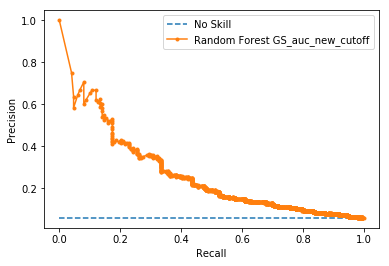

In [32]:
rft_gsa_new_co_f1, rft_gsa__new_co_precision, rft_gsa_new_co_recall = metrics.plot_prec_rec(y_test,data['pred'],
                                                                                            rft_gsa_prob,
                                                                                            'Random Forest GS_auc_new_cutoff')

**The results are not fully comparable** since I have not used cross-validation for recall and f1 in this second scenario but it gives us an clue of improvement by selecting a more appropriate cut-off

In [33]:
result['clf_rf_tuned_gsa_new_co'] = [recall_score(y_test,data['pred']),
                                     rft_gsa_auc_roc,
                                     rft_gsa_new_co_f1]

In [34]:
result

,clf_rf_tuned_rs,clf_rf_tuned_gsr,clf_rf_tuned_gsa,clf_rf_tuned_gsa_new_co
recall,0.677852,0.684564,0.610738,0.697987
auc_roc,0.701643,0.718005,0.758004,0.758004
f1,0.173540,0.183950,0.231258,0.213772


**Optimal cut off for classifier that optimizes recall (clf_rft_gsr)**   
This is the Random Forest classifier fit for the global modeling scenarios comparison. See [Data_modeling_notebook](./TBV1_classification_model.ipynb)

In [36]:
# Add prediction probability to dataframe
data = pd.DataFrame()
data['pred_proba'] = pd.Series(rft_gsr_prob)

# Find optimal probability threshold
threshold = metrics.Find_Optimal_Cutoff(y_test,data['pred_proba'])

# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
metrics.plot_cm(y_test,data['pred'])

The optimal cut-off is: 0.51
Confusion matrix:
[[1571  815]
 [  51   98]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      2386
           1       0.11      0.66      0.18       149

    accuracy                           0.66      2535
   macro avg       0.54      0.66      0.48      2535
weighted avg       0.92      0.66      0.75      2535



In [37]:
#Save the model
import pickle
# save models to disk (tined RF and tuned xgb)
pickle.dump(clf_rft_rs,open('clf_rft_rs.pkl','wb'))
pickle.dump(clf_rft_gsr,open('clf_rft_gsr.pkl','wb'))
pickle.dump(clf_rft_gsa,open('clf_rft_gsa.pkl','wb'))